In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [4]:
# dataset setelah feature selection pada pre-processing
dataset = pd.read_csv('../dataset/after_selection/train.csv')

In [5]:
dataset.head()

,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Age_Bin,Vehicle_Damage_Age_Interaction,Response
0,1,46.0,1,0,0,152.0,0,0,0
1,1,46.0,1,0,0,152.0,0,0,0
2,1,46.0,1,1,1,26.0,2,2,0
3,1,18.0,1,0,0,152.0,1,0,0
4,1,11.0,0,1,1,122.0,2,2,0


### Memisahkan Feature dan Target

In [7]:
X = dataset.drop(columns=['Response'])
y = dataset['Response']

### Split Dataset

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train.head()

,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Age_Bin,Vehicle_Damage_Age_Interaction
19573,1,28.0,0,1,1,26.0,2,2
28898,1,28.0,1,0,0,152.0,0,0
3170,1,30.0,1,0,0,152.0,1,0
18784,1,6.0,1,0,1,152.0,0,0
29070,1,7.0,1,0,0,160.0,0,0


In [10]:
y_train.sample(5)

9470     0
76920    1
36152    0
11489    0
78982    1
Name: Response, dtype: int64

### Latih dan Evaluasi Model

In [11]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [12]:
y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
def eval(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print('Accuracy (test): %.2f' % accuracy_score(y_test, y_pred))
    print('Precision (test): %.2f' % precision_score(y_test, y_pred))
    print('Recall (test): %.2f' % recall_score(y_test, y_pred))

    print('AUC (test-proba): %.2f' % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print('AUC (train-proba): %.2f' % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

    score = cross_validate(dt, X, y, cv=5, scoring='roc_auc', return_train_score=True)
    print('roc_auc (crossval train): ' + str(score['train_score'].mean())) 
    print('roc_auc (crossval test): ' + str(score['test_score'].mean()))

In [14]:
eval(dt)

Accuracy (test): 0.79
Precision (test): 0.73
Recall (test): 0.91
AUC (test-proba): 0.83
AUC (train-proba): 0.88
roc_auc (crossval train): 0.8766399663306157
roc_auc (crossval test): 0.831875445299015


Response sudah balance karena telah dilakukan undersampling pada tahap pre-processing. Oleh karena itu metric evaluasi yang digunakan adalah **Recall**.
Recall digunakan untuk meminimalisir nilai False Negative. 

Recall digunakan untuk kasus ini agar customer yang diprediksi tidak tertarik, namun sebenarnya tertarik, tidak terlewat.
Sehingga mengurangi resiko potensi profit yang hilang. 

Walaupun nilai Recall sudah cukup baik (91%), namun jika dilihat dari roc_auc score, dapat dikatakan bahwa model sedikit mengalami overfitting. Oleh karena itu perlu dilakukan hyperparameter tuning.

### Hyperparameter Tuning

In [15]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import numpy as np 

# List of Hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num=30)]
min_samples_split = [2, 5, 10, 50, 100]
min_samples_leaf = [1, 2, 4, 10, 20, 50]
max_features = ['auto', 'sqrt']
criterion = ['gini', 'entropy']
splitter = ['best', 'random']

hyperparameters = dict(max_depth=max_depth,
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                       )

# inisialisasi model
dt=DecisionTreeClassifier(random_state=42)
model = RandomizedSearchCV(dt, hyperparameters, cv=5, scoring='recall') 
model.fit(X_train, y_train)

# predict and evaluation
y_pred = model.predict(X_test)
eval(model)

Accuracy (test): 0.78
Precision (test): 0.70
Recall (test): 0.98
AUC (test-proba): 0.82
AUC (train-proba): 0.82
roc_auc (crossval train): 0.8766399663306157
roc_auc (crossval test): 0.8318803386914162


Hasil hyperparameter tuning mampu meningkatkan Recall Score secara signifikan, yaitu dari 91% menjadi 98%. Namun masih mengalami overfitting.

### Feature Importance

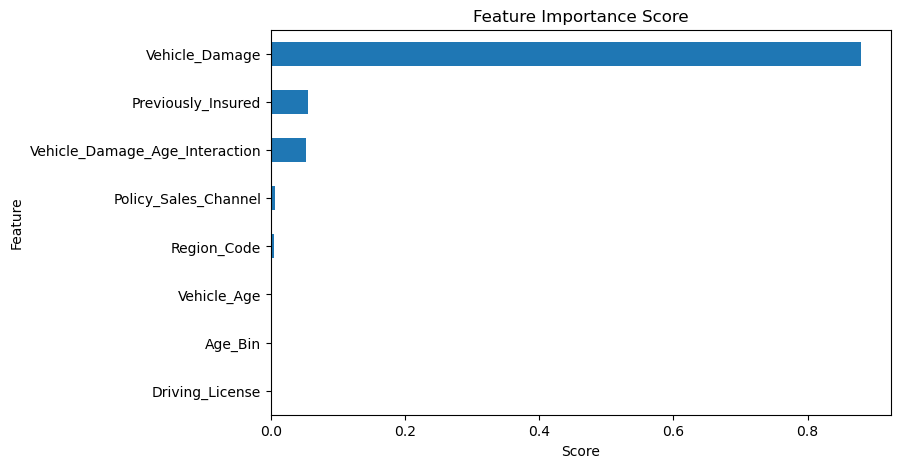

In [16]:
import matplotlib.pyplot as plt

def show_feature_importance(model):
    feat_importance = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importance.nlargest(25).plot(kind='barh', figsize=(8, 5))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score')

show_feature_importance(model.best_estimator_)

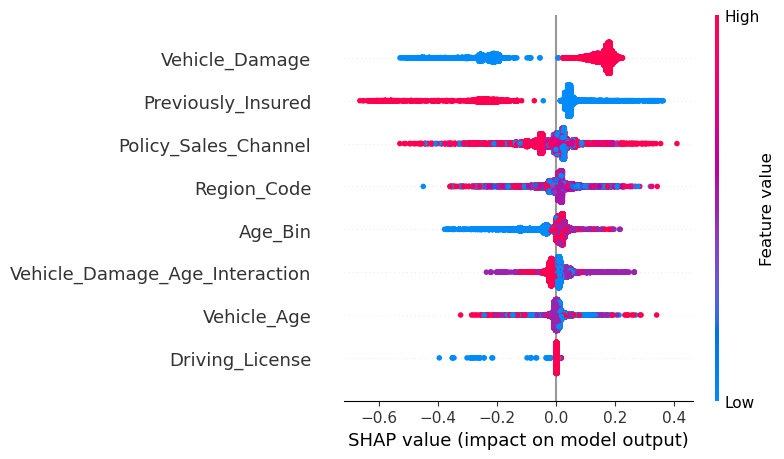

In [17]:
import shap
from sklearn.tree import DecisionTreeClassifier

# Assuming dt is your DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Create a TreeExplainer using model_output="raw"
explainer = shap.TreeExplainer(dt, model_output='raw')
shap_values = explainer.shap_values(X_test)

# create a summary plot for the positive class (class 1)
class_index = 1

# Select the SHAP values for the specified class
shap_values_class = shap_values[class_index]

# Create a summary plot
shap.summary_plot(shap_values_class, X_test)


Dilihat dari 2 plot di atas dapat disimpulkan bahwa feature yang mempunyai pengaruh cukup signifikan terhadap target adalah Vehicle Damage, Previously Insured, dan Age. 

Adapun Insight yang diperoleh dari summary plot yaitu: Customer yang berpeluang lebih besar untuk tertarik pada asuransi kendaraan adalah customer yang **pernah mengalami kerusakan kendaraan**, **belum memiliki asuransi kendaraan sebelumnya**, dan **berusia relatif lebih matang**.

### Revisi Evaluation Metrics

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold


def eval_classification(model, X_train, X_test, y_train, y_test, n_splits=5):
    # Evaluate on the test set
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # Display metrics for the training set
    print("Metrics for the Test Set:")
    print("Accuracy: %.2f" % accuracy_score(y_test, y_pred_test))
    print("Precision: %.2f" % precision_score(y_test, y_pred_test))
    print("Recall: %.2f" % recall_score(y_test, y_pred_test))
    print("F1-Score: %.2f" % f1_score(y_test, y_pred_test))
    print()

    # StratifiedKFold for cross-validation with stratified sampling
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_test_results = cross_validate(model, X_test, y_test, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    cv_train_results = cross_validate(model, X_train, y_train, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)

    # Display cross-validation results
    print("Metrics Using Cross Validation:")
    print(f"Mean ROC-AUC (Test): {cv_test_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Test): {cv_test_results['test_roc_auc'].std():.2f}")
    print()
    print(f"Mean ROC-AUC (Train): {cv_train_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Train): {cv_train_results['test_roc_auc'].std():.2f}")

In [115]:
eval_classification(dt, X_train, X_test, y_train, y_test, n_splits=5)

Metrics for the Test Set:
Accuracy: 0.79
Precision: 0.73
Recall: 0.91
F1-Score: 0.81

Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.82
Std ROC-AUC (Test): 0.00

Mean ROC-AUC (Train): 0.83
Std ROC-AUC (Train): 0.00
